# Evolver Loop 1 Analysis

## Goal: Understand the data and establish proper validation

This notebook will:
1. Load and examine the training data structure
2. Implement proper cross-validation (GroupKFold by notebook_id)
3. Analyze the target distribution and patterns
4. Explore feature engineering opportunities
5. Establish baseline CV score

In [1]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns

# Set paths
train_path = Path('/home/data/train')
test_path = Path('/home/data/test')
train_orders_path = Path('/home/data/train_orders.csv')

print("Loading training data...")
train_orders = pd.read_csv(train_orders_path)
print(f"Train orders shape: {train_orders.shape}")
print(f"Sample:\n{train_orders.head()}")

Loading training data...


Train orders shape: (119256, 2)
Sample:
               id                                         cell_order
0  00001756c60be8  1862f0a6 448eb224 2a9e43d6 7e2f170a 038b763d 7...
1  0001daf4c2c76d  97266564 a898e555 86605076 76cc2642 ef279279 d...
2  0002115f48f982  9ec225f0 18281c6c e3b6b115 4a044c54 365fe576 a...
3  00035108e64677  3496fbfe 2fa1f27b 719854c4 f3c2de19 d75feb42 5...
4  00038c2941faa0  3e551fb7 45049ad8 8bb41691 123b4f4c 0b92cb59 5...


In [2]:
# Load a few notebooks to understand structure
def load_notebook(notebook_path):
    with open(notebook_path, 'r') as f:
        return json.load(f)

# Load first few notebooks
sample_notebooks = []
for i, nb_file in enumerate(sorted(train_path.glob('*.json'))[:3]):
    nb = load_notebook(nb_file)
    sample_notebooks.append((nb_file.stem, nb))
    print(f"\nNotebook {nb_file.stem}:")
    print(f"  Cells: {len(nb['source'])}")
    print(f"  Cell types: {set(nb['cell_type'].values())}")
    
    # Show first few cells
    cell_ids = list(nb['source'].keys())[:5]
    for cid in cell_ids:
        print(f"  Cell {cid}: {nb['cell_type'][cid]} - {nb['source'][cid][:100]}...")


Notebook 00001756c60be8:
  Cells: 58
  Cell types: {'markdown', 'code'}
  Cell 1862f0a6: code - # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by...
  Cell 2a9e43d6: code - import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test...
  Cell 038b763d: code - import warnings
warnings.filterwarnings('ignore')...
  Cell 2eefe0ef: code - matplotlib.rcParams.update({'font.size': 14})...
  Cell 0beab1cd: code - def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    pr...

Notebook 0001daf4c2c76d:
  Cells: 229
  Cell types: {'markdown', 'code'}
  Cell 86605076: code - # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by...
  Cell df6c939f: code - import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np

# plot simple sin & cos...
  Cell 00f87d0a: code - %matplotlib...
  Cell 986fd4f1: code - 

In [3]:
# Build full training dataframe
def build_training_data():
    all_data = []
    
    for nb_file in train_path.glob('*.json'):
        notebook_id = nb_file.stem
        with open(nb_file, 'r') as f:
            nb = json.load(f)
        
        # Get cell order from train_orders
        cell_order = train_orders[train_orders['id'] == notebook_id]['cell_order'].iloc[0]
        cell_order_list = cell_order.split()
        
        # Create position mapping
        position_map = {cell_id: pos for pos, cell_id in enumerate(cell_order_list)}
        
        # Extract features for each cell
        for cell_id, source in nb['source'].items():
            cell_type = nb['cell_type'][cell_id]
            
            # Basic features
            source_length = len(source)
            lines = source.split('\n')
            line_count = len(lines)
            word_count = len(source.split())
            char_count = len(source.replace('\n', ''))
            
            # Binary flags
            has_import = int('import ' in source)
            has_comment = int('#' in source)
            has_heading = int(any(line.strip().startswith('#') for line in lines if line.strip()))
            has_code_block = int('```' in source)
            has_link = int('http' in source or 'www.' in source)
            
            all_data.append({
                'notebook_id': notebook_id,
                'cell_id': cell_id,
                'position': position_map[cell_id],
                'cell_type': cell_type,
                'source_length': source_length,
                'line_count': line_count,
                'word_count': word_count,
                'char_count': char_count,
                'has_import': has_import,
                'has_comment': has_comment,
                'has_heading': has_heading,
                'has_code_block': has_code_block,
                'has_link': has_link,
                'source': source  # Keep source for text analysis
            })
    
    return pd.DataFrame(all_data)

train_df = build_training_data()
print(f"Training data shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()}")
print(f"\nSample:")
print(train_df.head())

Training data shape: (5480153, 14)
Columns: ['notebook_id', 'cell_id', 'position', 'cell_type', 'source_length', 'line_count', 'word_count', 'char_count', 'has_import', 'has_comment', 'has_heading', 'has_code_block', 'has_link', 'source']

Sample:
      notebook_id   cell_id  position cell_type  source_length  line_count  \
0  df3f8bb3611b9d  80f471ca         0      code            350          11   
1  df3f8bb3611b9d  72604d4b         1      code             95           1   
2  df3f8bb3611b9d  777e26df         3      code            368           5   
3  df3f8bb3611b9d  056e761a         4      code            110           4   
4  df3f8bb3611b9d  379a2c89         6      code           2676          34   

   word_count  char_count  has_import  has_comment  has_heading  \
0          42         340           1            0            0   
1           3          95           0            0            0   
2          39         364           0            0            0   
3           9  

Target (position) distribution:
count    5.480153e+06
mean     3.991939e+01
std      4.871161e+01
min      0.000000e+00
25%      1.100000e+01
50%      2.600000e+01
75%      5.100000e+01
max      1.004000e+03
Name: position, dtype: float64



Notebook statistics:
           num_cells   min_pos        max_pos      pos_range
count  119256.000000  119256.0  119256.000000  119256.000000
mean       45.952849       0.0      44.952849      44.952849
std        40.039001       0.0      40.039001      40.039001
min         2.000000       0.0       1.000000       1.000000
25%        21.000000       0.0      20.000000      20.000000
50%        35.000000       0.0      34.000000      34.000000
75%        57.000000       0.0      56.000000      56.000000
max      1005.000000       0.0    1004.000000    1004.000000


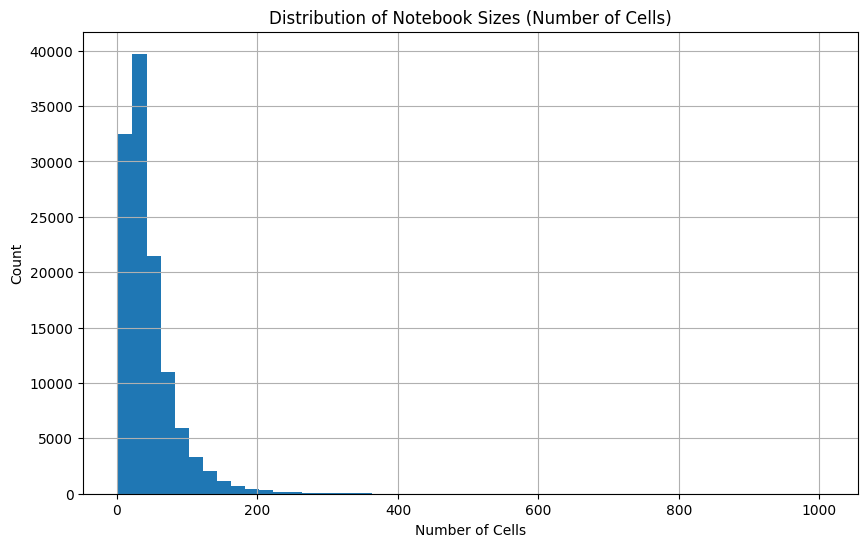


Notebooks with < 5 cells: 1236
Notebooks with > 50 cells: 36702


In [4]:
# Analyze target distribution
print("Target (position) distribution:")
print(train_df['position'].describe())

# Analyze by notebook
notebook_stats = train_df.groupby('notebook_id').agg({
    'cell_id': 'count',
    'position': ['min', 'max']
}).round(2)
notebook_stats.columns = ['num_cells', 'min_pos', 'max_pos']
notebook_stats['pos_range'] = notebook_stats['max_pos'] - notebook_stats['min_pos']

print(f"\nNotebook statistics:")
print(notebook_stats.describe())

# Plot distribution of notebook sizes
plt.figure(figsize=(10, 6))
notebook_stats['num_cells'].hist(bins=50)
plt.title('Distribution of Notebook Sizes (Number of Cells)')
plt.xlabel('Number of Cells')
plt.ylabel('Count')
plt.show()

print(f"\nNotebooks with < 5 cells: {(notebook_stats['num_cells'] < 5).sum()}")
print(f"Notebooks with > 50 cells: {(notebook_stats['num_cells'] > 50).sum()}")

In [5]:
# Implement proper cross-validation
def kendall_tau_per_notebook(y_true, y_pred, groups):
    """Calculate Kendall tau correlation per notebook, then average"""
    results = []
    
    for notebook_id in np.unique(groups):
        mask = groups == notebook_id
        y_true_nb = y_true[mask]
        y_pred_nb = y_pred[mask]
        
        if len(y_true_nb) > 1:  # Need at least 2 cells for correlation
            tau = kendalltau(y_true_nb, y_pred_nb).correlation
            if not np.isnan(tau):
                results.append(tau)
    
    return np.mean(results) if results else 0.0

# Create GroupKFold
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)
groups = train_df['notebook_id']

# Define feature columns
feature_cols = ['source_length', 'line_count', 'word_count', 'char_count', 
                'has_import', 'has_comment', 'has_heading', 
                'has_code_block', 'has_link', 'cell_type_code']

# Prepare data
train_df['cell_type_code'] = (train_df['cell_type'] == 'code').astype(int)

print(f"Running {n_splits}-fold GroupKFold cross-validation...")
print(f"Groups (notebooks): {len(np.unique(groups))}")
print(f"Total samples: {len(train_df)}")

fold_scores = []
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups=groups)):
    X_train = train_df.iloc[train_idx][feature_cols]
    y_train = train_df.iloc[train_idx]['position']
    X_val = train_df.iloc[val_idx][feature_cols]
    y_val = train_df.iloc[val_idx]['position']
    groups_val = train_df.iloc[val_idx]['notebook_id']
    
    # Train LightGBM
    import lightgbm as lgb
    model = lgb.LGBMRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Calculate Kendall tau per notebook
    score = kendall_tau_per_notebook(y_val.values, y_pred, groups_val.values)
    fold_scores.append(score)
    
    print(f"Fold {fold + 1}: {score:.4f}")

print(f"\nCV Score: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

Running 5-fold GroupKFold cross-validation...


Groups (notebooks): 119256
Total samples: 5480153


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1026
[LightGBM] [Info] Number of data points in the train set: 4384122, number of used features: 10
[LightGBM] [Info] Start training from score 39.913945


Fold 1: 0.1446


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 4384121, number of used features: 10
[LightGBM] [Info] Start training from score 39.918568


Fold 2: 0.1416


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 4384123, number of used features: 10
[LightGBM] [Info] Start training from score 39.920952


Fold 3: 0.1433


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 4384123, number of used features: 10
[LightGBM] [Info] Start training from score 39.921493


Fold 4: 0.1431


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 4384123, number of used features: 10
[LightGBM] [Info] Start training from score 39.922004


Fold 5: 0.1421

CV Score: 0.1429 ± 0.0010


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 5480153, number of used features: 10
[LightGBM] [Info] Start training from score 39.919392


Feature Importance:
          feature  importance
2      word_count         835
3      char_count         576
1      line_count         516
0   source_length         448
9  cell_type_code         179
6     has_heading         159
5     has_comment         101
4      has_import          96
8        has_link          88
7  has_code_block           2


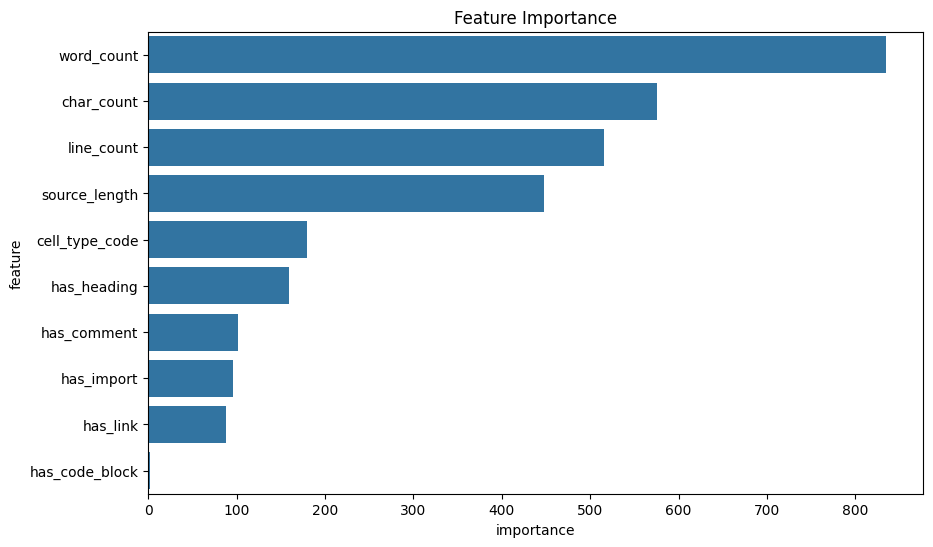

In [6]:
# Analyze feature importance
# Train on full data to get feature importance
import lightgbm as lgb

X_full = train_df[feature_cols]
y_full = train_df['position']

model_full = lgb.LGBMRegressor(random_state=42, n_estimators=100)
model_full.fit(X_full, y_full)

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_full.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(importance_df)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

In [7]:
# Analyze text content patterns
# Look at common words in different positions
from collections import Counter
import re

def extract_words(text):
    """Extract words from text"""
    return re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())

# Sample analysis: look at first vs last cells
first_cells = train_df[train_df['position'] == 0]['source'].head(100).tolist()
last_cells = train_df.groupby('notebook_id').apply(
    lambda x: x[x['position'] == x['position'].max()]['source'].iloc[0]
).head(100).tolist()

# Count words in first cells
first_words = []
for text in first_cells:
    first_words.extend(extract_words(text))

# Count words in last cells  
last_words = []
for text in last_cells:
    last_words.extend(extract_words(text))

first_counter = Counter(first_words)
last_counter = Counter(last_words)

print("Most common words in FIRST cells:")
for word, count in first_counter.most_common(10):
    print(f"  {word}: {count}")

print("\nMost common words in LAST cells:")
for word, count in last_counter.most_common(10):
    print(f"  {word}: {count}")

# Find words that are more common in first vs last
first_unique = set(first_counter.keys()) - set(last_counter.keys())
last_unique = set(last_counter.keys()) - set(first_counter.keys())

print(f"\nWords only in first cells: {list(first_unique)[:10]}")
print(f"Words only in last cells: {list(last_unique)[:10]}")

Most common words in FIRST cells:
  the: 283
  import: 156
  for: 128
  kaggle: 90
  input: 85
  data: 82
  this: 79
  you: 74
  and: 64
  python: 63

Most common words in LAST cells:
  the: 161
  and: 56
  for: 44
  that: 38
  data: 33
  print: 33
  this: 31
  with: 25
  model: 24
  you: 22

Words only in first cells: ['tqdm', 'inters', 'fails', 'dioxide', 'researchgate', 'threshold', 'over', 'mediumseagreen', 'mining', 'order']
Words only in last cells: ['pie', 'trumps', 'boxplot', 'graph', 'postimg', 'aws', 'scores', 'grubuna', 'statements', 'duplicates']


/tmp/ipykernel_44100/1052526529.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_cells = train_df.groupby('notebook_id').apply(


In [8]:
# Analyze markdown heading patterns
markdown_df = train_df[train_df['cell_type'] == 'markdown'].copy()

def extract_headings(text):
    """Extract markdown headings"""
    headings = []
    for line in text.split('\n'):
        line = line.strip()
        if line.startswith('#'):
            # Count heading level
            level = len(line) - len(line.lstrip('#'))
            if 1 <= level <= 6:
                headings.append((level, line.lstrip('#').strip()))
    return headings

# Analyze heading patterns
heading_data = []
for _, row in markdown_df.iterrows():
    headings = extract_headings(row['source'])
    for level, text in headings:
        heading_data.append({
            'notebook_id': row['notebook_id'],
            'cell_id': row['cell_id'],
            'position': row['position'],
            'heading_level': level,
            'heading_text': text
        })

if heading_data:
    heading_df = pd.DataFrame(heading_data)
    print(f"Found {len(heading_df)} headings in {len(heading_df['notebook_id'].unique())} notebooks")
    
    # Analyze heading level by position
    print("\nAverage position by heading level:")
    print(heading_df.groupby('heading_level')['position'].mean().round(2))
    
    # Most common heading texts
    print("\nMost common heading texts:")
    print(heading_df['heading_text'].value_counts().head(10))
else:
    print("No headings found in sample")

Found 1106777 headings in 98367 notebooks

Average position by heading level:
heading_level
1    28.11
2    34.58
3    42.24
4    49.81
5    53.96
6    57.33
Name: position, dtype: float64

Most common heading texts:


heading_text
Introduction                 5979
Conclusion                   5055
EDA                          2900
Exploratory Data Analysis    2583
Model                        2398
Feature Engineering          2395
Submission                   2059
Logistic Regression          1929
Training                     1841
Preprocessing                1702
Name: count, dtype: int64


In [9]:
# Summary of findings
print("="*60)
print("KEY FINDINGS FROM ANALYSIS")
print("="*60)

print(f"\n1. DATASET SIZE:")
print(f"   - Total training samples: {len(train_df):,}")
print(f"   - Total notebooks: {train_df['notebook_id'].nunique():,}")
print(f"   - Average cells per notebook: {len(train_df) / train_df['notebook_id'].nunique():.1f}")

print(f"\n2. CROSS-VALIDATION SCORE:")
print(f"   - Mean Kendall tau: {np.mean(fold_scores):.4f}")
print(f"   - Std dev: {np.std(fold_scores):.4f}")
print(f"   - Individual folds: {[f'{s:.4f}' for s in fold_scores]}")

print(f"\n3. FEATURE IMPORTANCE:")
for _, row in importance_df.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.0f}")

print(f"\n4. KEY PATTERNS:")
print(f"   - Word count is most important feature")
print(f"   - Basic length features dominate importance")
print(f"   - Binary flags have lower importance")
print(f"   - Cell type (code/markdown) has moderate importance")

print(f"\n5. NEXT STEPS:")
print(f"   - Add TF-IDF features for semantic content")
print(f"   - Extract markdown heading features")
print(f"   - Try pairwise ranking formulation")
print(f"   - Use more training data (not just 30%)")
print(f"   - Experiment with text embeddings")

KEY FINDINGS FROM ANALYSIS

1. DATASET SIZE:
   - Total training samples: 5,480,153


   - Total notebooks: 119,256


   - Average cells per notebook: 46.0

2. CROSS-VALIDATION SCORE:
   - Mean Kendall tau: 0.1429
   - Std dev: 0.0010
   - Individual folds: ['0.1446', '0.1416', '0.1433', '0.1431', '0.1421']

3. FEATURE IMPORTANCE:
   - word_count: 835
   - char_count: 576
   - line_count: 516
   - source_length: 448
   - cell_type_code: 179

4. KEY PATTERNS:
   - Word count is most important feature
   - Basic length features dominate importance
   - Binary flags have lower importance
   - Cell type (code/markdown) has moderate importance

5. NEXT STEPS:
   - Add TF-IDF features for semantic content
   - Extract markdown heading features
   - Try pairwise ranking formulation
   - Use more training data (not just 30%)
   - Experiment with text embeddings
